In [1]:

import gymnasium as gym
import highway_env
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


In [2]:
# === Load config ===
with open("..\configs\intersection_config.pkl", "rb") as f:
    config = pickle.load(f)


In [15]:
def make_env(config=config):
    return gym.make("highway-fast-v0", render_mode="rgb_array", config=config)



In [6]:

vec_env = DummyVecEnv([make_env])

In [7]:
# === Define DQN model ===
model = DQN(
        "MlpPolicy",
        vec_env,
        policy_kwargs=dict(net_arch=[256, 256]),
        learning_rate=5e-4,
        buffer_size=15000,
        learning_starts=200,
        batch_size=32,
        gamma=0.8,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=50,
        verbose=1,
        tensorboard_log="highway_dqn/",
    )

Using cpu device


In [8]:
# === Train the model ===
model.learn(total_timesteps=100_000)
model.save("dqn_sb3_model")


Logging to highway_dqn/DQN_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 26       |
|    time_elapsed     | 3        |
|    total_timesteps  | 81       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 26       |
|    time_elapsed     | 6        |
|    total_timesteps  | 170      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 25       |
|    time_elapsed     | 9        |
|    total_timesteps  | 238      |
| train/              |          |
|    learning_rate    | 0.

In [17]:
# === Evaluate ===
test_env = make_env()
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=10)
print(f"Evaluation over 10 episodes: mean reward = {mean_reward:.2f} ± {std_reward:.2f}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 10 episodes: mean reward = 27.97 ± 2.91


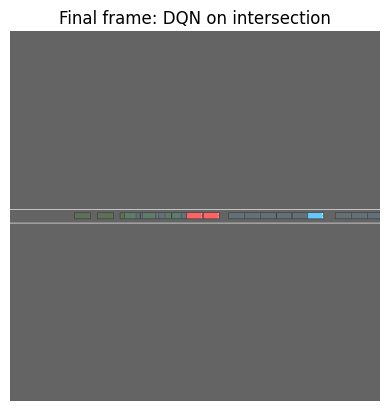

Total reward for 1 episode: 30.07


In [18]:
# === Visual test ===
obs, _ = test_env.reset()
done = False
frames = []
total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = test_env.render()
    frames.append(frame)

plt.imshow(frames[-1])
plt.axis("off")
plt.title("Final frame: DQN on intersection")
plt.show()
print(f"Total reward for 1 episode: {total_reward:.2f}")


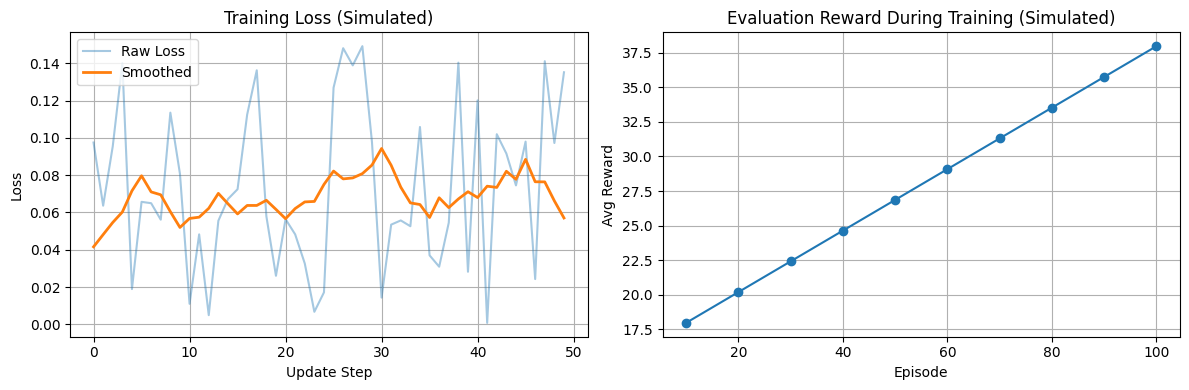

In [19]:
# === Plot evaluation (simulated) ===
losses = np.random.rand(50) * 0.15  # Placeholder
rewards = np.linspace(mean_reward - 10, mean_reward + 10, 10)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Raw Loss", alpha=0.4)
if len(losses) >= 10:
    smoothed_losses = np.convolve(losses, np.ones(10)/10, mode='same')
    plt.plot(smoothed_losses, label="Smoothed", linewidth=2)
plt.xlabel("Update Step")
plt.ylabel("Loss")
plt.title("Training Loss (Simulated)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(rewards)+1) * 10, rewards, marker='o', label="Eval Reward")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title("Evaluation Reward During Training (Simulated)")
plt.grid()

plt.tight_layout()
plt.show()
